# visualizing synthetic landscape + SGD

## imports

### mount drive


In [1]:
COLAB = False
if COLAB == True:
    drive.mount('/content/drive')

### pip installs

In [2]:
if COLAB==True:
    !pip install scanpy moscot ott-jax diffrax napari anndata -q
    !pip install "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html -q

### imports

In [3]:
import math, napari, numpy as np
import pandas as pd

from scipy.optimize import minimize
from scipy.ndimage import minimum_filter

import importlib

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import sys, pathlib

if COLAB == True:
    fh_hmot = "/content/drive/Othercomputers/numac/GitHub/HM-OT" # filehandle for HM-OT
    project_root = pathlib.Path(fh_hmot)
    sys.path.insert(0, fh_hmot)
    sys.path.insert(0, str(project_root / "src"))
else: 
    fh_hmot = '../'
    project_root = pathlib.Path(fh_hmot)
    sys.path.insert(0, fh_hmot)

from src.utils.waddington import viewer, visual, minima, simulation, differentiation, metrics
from src.utils.waddington import seed_everything
from src.platting import color_utils, palette_utils, string_utils, spatial_scatter, diffmap

## set seed

In [4]:
# Set global seed for reproducibility
GLOBAL_SEED = 42
# np.random.seed(GLOBAL_SEED)
seed = seed_everything(GLOBAL_SEED)

🌱 Setting global seed to 42
  ⚠ PyTorch not available
  ⚠ JAX not available
🌱 All available RNGs seeded.


## set parameters (`TIMEPOINTS`, `ASSIGNMENT_RADIUS`, `LANGEVIN` parameters)

In [7]:
%%time
# timepoint indices of snapshots of Langevin dynamics
TIMEPOINTS = [19, 89, 2500] # snapshots taken at these timepoints

# assignment radius (determines cell type assignments):
ASSIGNMENT_RADIUS = 1.6

# Langevin dynamics parameteters
LANGEVIN_n_particles = 100 # number of partciles
LANGEVIN_N_timesteps = 3000 # number of time steps
LANGEVIN_dt = 0.2
LANGEVIN_D = 0.014


SHOW_DYN = True # Set to True to visualize dynamics with napari
# ------------------------------------------------------------------
if __name__ == "__main__" and SHOW_DYN:
    try:
        viewer.launch_viewer_with_differentiation(
            timepoints=TIMEPOINTS,
            langevin_n=LANGEVIN_n_particles,
            langevin_N=LANGEVIN_N_timesteps,
            langevin_dt=LANGEVIN_dt,
            langevin_D=LANGEVIN_D,
            assignment_radius=ASSIGNMENT_RADIUS)
        napari.run()
    except Exception as e:
        print("Napari error:", e)
        print("Install with: pip install 'napari[all]' scipy")
elif SHOW_DYN==False:
    img = Image.open(fh_hmot + '/experiments/2.png')
    img

Finding local minima …
→ 15 minima found
Building coloured surface …
Running Langevin simulation …
Constructing differentiation map …
Play ▶︎ to animate.
CPU times: user 19.5 s, sys: 852 ms, total: 20.3 s
Wall time: 20.3 s


Assignment radius: 1.6
Verification (polar coords):
(-1.564, -2.709)  r= 3.13  θ= 240.0° → A240
( 3.128,  0.000)  r= 3.13  θ=   0.0° → A0
(-1.564,  2.709)  r= 3.13  θ= 120.0° → A120
(-4.799, -2.796)  r= 5.55  θ= 210.2° → B210
(-4.799,  2.796)  r= 5.55  θ= 149.8° → B150
( 4.821, -2.758)  r= 5.55  θ= 330.2° → B330
( 4.821,  2.758)  r= 5.55  θ=  29.8° → B30
(-0.022, -5.555)  r= 5.55  θ= 269.8° → B270
(-0.022,  5.555)  r= 5.55  θ=  90.2° → B90
(-7.705, -4.448)  r= 8.90  θ= 210.0° → C210
( 7.705, -4.448)  r= 8.90  θ= 330.0° → C330
( 7.705,  4.448)  r= 8.90  θ=  30.0° → C30
(-7.705,  4.448)  r= 8.90  θ= 150.0° → C150
(-0.000, -8.897)  r= 8.90  θ= 270.0° → C270
(-0.000,  8.897)  r= 8.90  θ=  90.0° → C90


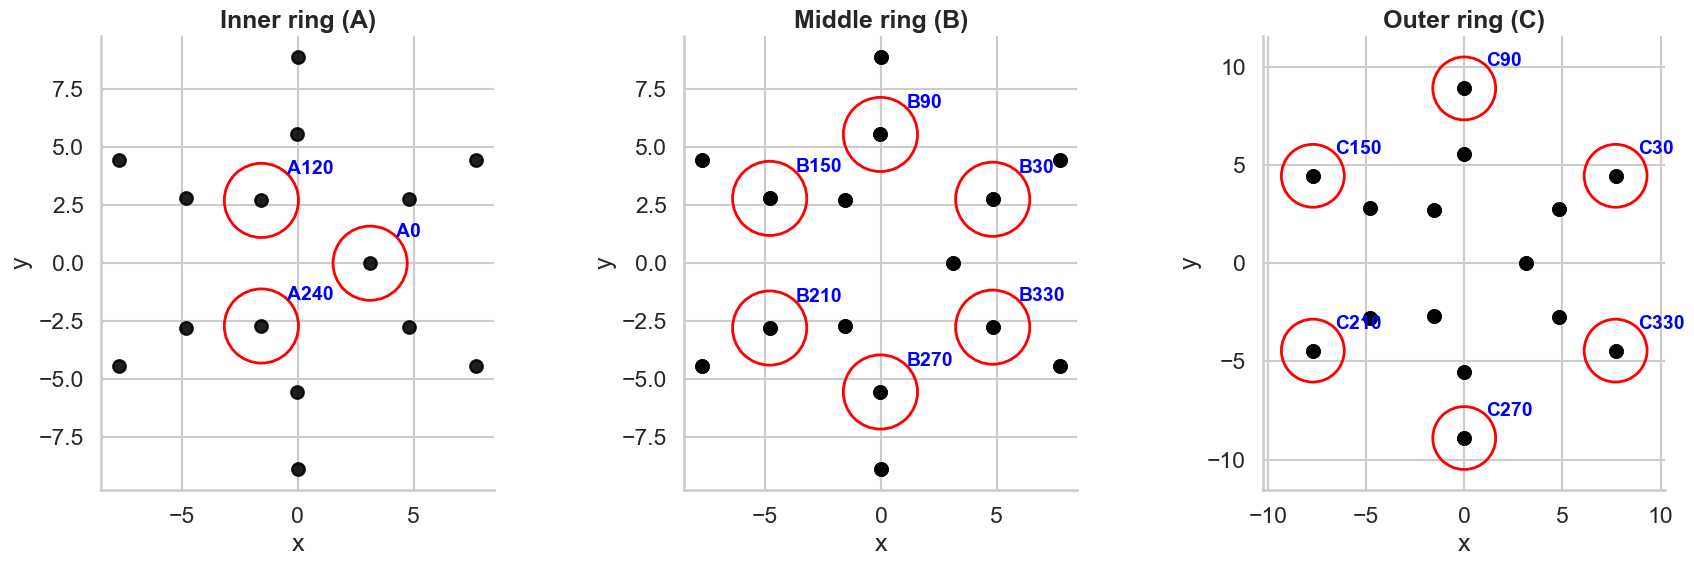


Total clusters: 15


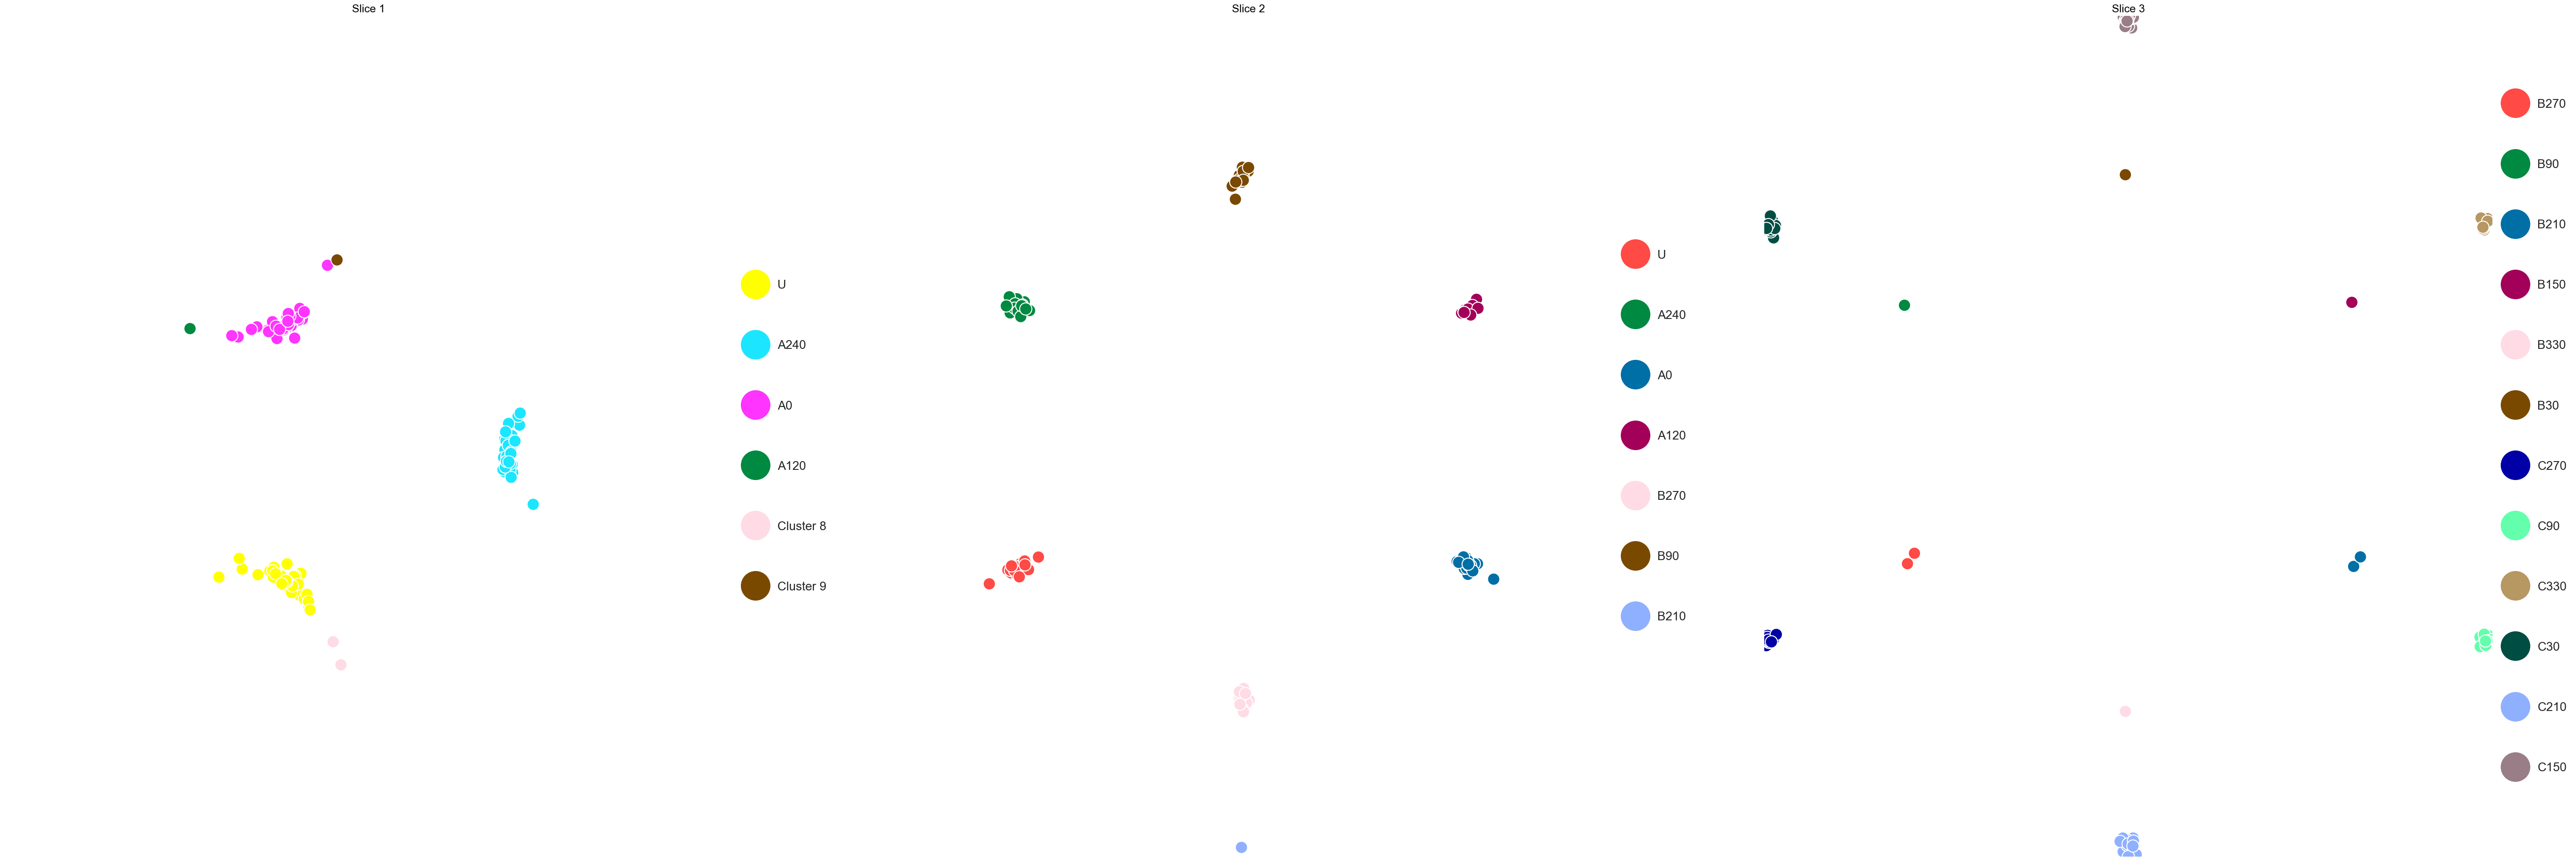

In [6]:
# assignment radius (determines cell type assignments):
ASSIGNMENT_RADIUS = 1.6

MINIMA_POINTS = minima.find_local_minima()
# local minima of the Waddington landscape
# (+ ASSIGNMENT_RADIUS) determine cell type
cluster_dict = visual.create_cluster_dict_and_plot(
    MINIMA_POINTS,
    ASSIGNMENT_RADIUS)

# snapshots = dynamics snapshots at each timepoint
Xs, Ys, snapshots = simulation.simulate_langevin_with_snapshots(
    n_particles=LANGEVIN_n_particles,
    n_steps=LANGEVIN_N_timesteps,
    dt=LANGEVIN_dt,
    diffusion=LANGEVIN_D,
    snap_times=TIMEPOINTS)

transition_maps, cell_assignments, type_labels = differentiation.build_differentiation_map(
    Xs, Ys, MINIMA_POINTS,
    timepoints=TIMEPOINTS,
    assignment_radius=ASSIGNMENT_RADIUS
)
keys = [f"t{TIMEPOINTS[0]}_to_t{TIMEPOINTS[1]}", f"t{TIMEPOINTS[1]}_to_t{TIMEPOINTS[2]}"]
matrices = [transition_maps[key] for key in keys]
dfs = [pd.DataFrame(mat, index=type_labels, columns=type_labels) for mat in matrices]

# gt cell type assignments
Ss = [
    np.stack((Xs[:, t], Ys[:, t]), axis=1)     # shape (N, 2)
    for t in TIMEPOINTS
]

Qs_gt_full =  minima.build_Qs(Ss, MINIMA_POINTS, ASSIGNMENT_RADIUS)

if GLOBAL_SEED == 42: #and TIMEPOINTS == [19, 42, 1100]:
    cell_type_labels_t1 = ['U','A240', 'A0', 'A120']
    cell_type_labels_t2 = ['U', 'A240', 'A0', 'A120', 'B270', 'B90', 'B210', 'B150', 'B330', 'B30']
    cell_type_labels_t3 = ['B270', 'B90', 'B210', 'B150', 'B330', 'B30', 'C270', 'C90', 'C330', 'C30', 'C210', 'C150']
    cell_type_labels = [cell_type_labels_t1, cell_type_labels_t2, cell_type_labels_t3]

spatial_scatter.plot_clusters_from_QT(
    Qs = Qs_gt_full,
    Ts = [None, None],
    Ss=Ss,
    cell_type_labels=cell_type_labels,
    dotsize=400.0,
    key_dotsize=1.0,
    global_Qs=True)